In [ ]:
import gc
import rope
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings("ignore")

In [45]:
# Assign column headers: id, te, (time evolutions) os1, os2, os3, (operational settings) s1, s2, ..., s21 (sensors)
sensor_name = ['s'+ str(i) for i in range(1,22)]
train.columns = ['id', 'te', 'os1', 'os2', 'os3'] + sensor_name

In [47]:
# print('Number of cycles per machine: ', train['id'].unique().size)
sensor='s'+'21'
sensor_all_times = train.ix[:,sensor]
sensor_1st_time = train.ix[train['id']==1,sensor]
plt.figure(1)
plt.plot(sensor_all_times)
plt.title('The signal from ' + sensor + ' in all times')
plt.figure(2)
plt.plot(sensor_1st_time)
plt.title('The signal from ' + sensor + ' in 1st time')


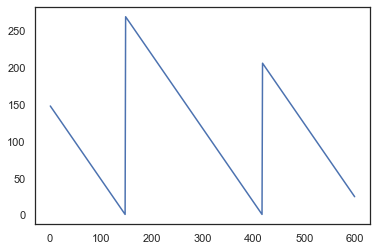

In [48]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  

train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

In [49]:
# prepare the data
# then split them into train and test sets
y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = pd.DataFrame(normalize(train[features], axis=0))
X.columns = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

Optimal value:  4.4302205772772525e-06
[ 1.90109755e+04 -6.20733614e+04 -7.36232016e+03  1.57382354e+06
 -3.25539089e+05 -3.93507505e+05 -4.57621062e+05 -6.87938514e+04
  3.22857959e+03  2.17841147e+04  1.13866064e+06 -4.56482021e+04
 -1.91098994e+04 -7.61664273e+05 -1.00133763e+03  2.51902190e+05
 -1.08411069e+06 -7.65798976e+05 -2.96750304e+03 -2.65420392e+05
  2.77331340e+05 -6.71506851e+05 -3.39633814e+04 -6.24922954e+03]
Useful sensors to predict RUL:  Index(['os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8',
       's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's20', 's21'],
      dtype='object')


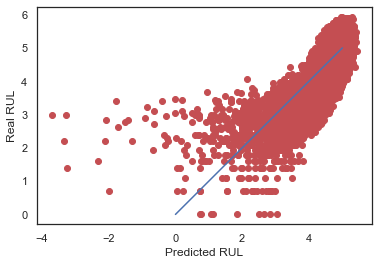

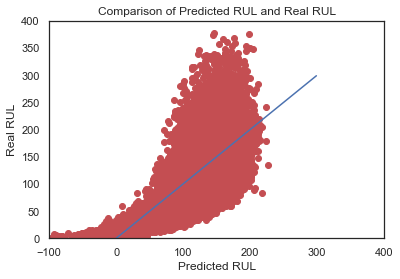

In [50]:
# try Lasso
ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(1)
plt.plot(np.log(ls.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))  # plot the line y = x of perfect prediction


Optimal value:  0.00809310955785962
[ 5.17342976e-02 -0.00000000e+00 -5.96739318e-02  2.40384048e-01
 -6.89382300e-02 -2.20707932e-02 -9.88513798e-03 -2.10839136e-01
 -5.63473904e-02  7.70061224e-03  2.42071653e-02 -2.31934154e-03
  0.00000000e+00 -6.21605356e-01 -2.74715421e-04  1.56574302e-03
 -5.29293833e-03 -6.06753815e+00 -0.00000000e+00 -1.02039661e-01
  8.24058041e-03 -2.18421751e-01 -2.48601828e-02 -0.00000000e+00]
Useful sensors to predict RUL:  Index(['os1', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
       's11', 's12', 's13', 's14', 's15', 's17', 's18', 's19', 's20'],
      dtype='object')


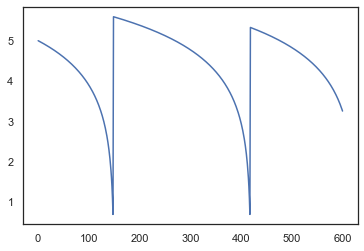

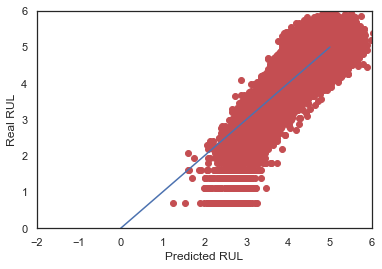

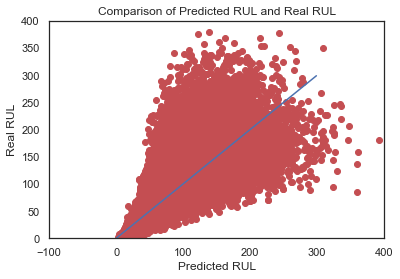

In [51]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Lasso
from sklearn.linear_model import LassoCV

ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(ls.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))

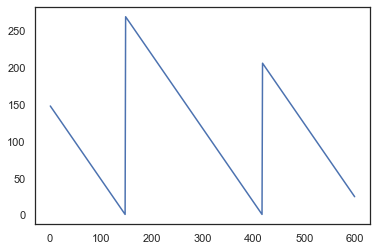

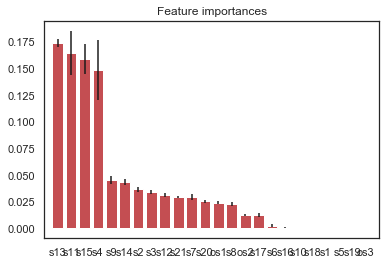

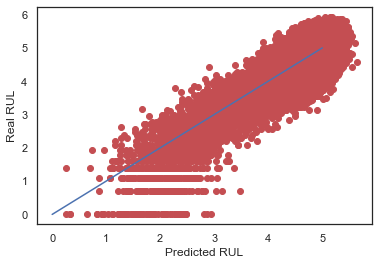

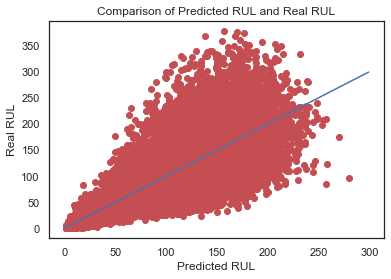

In [52]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1] 

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Random Forest
rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()


# compare predict RUL and real RUL
plt.figure(2)
plt.plot(np.log(rf.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

plt.figure(3)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))

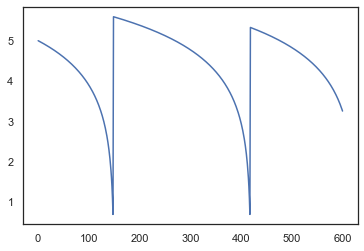

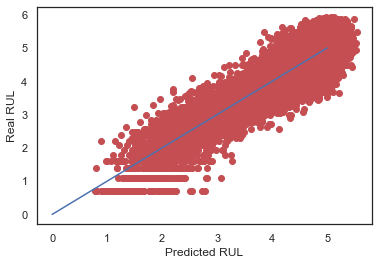

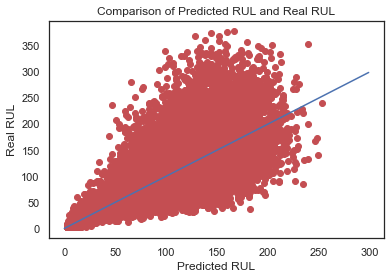

In [53]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
#plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(rf.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))